#Template for Basic Analysis of OpenStack Projects

Copyright Doug Williams - 2014, 2015

###Updated: 3/213/2015

###History
- 9/10/2014:  Initial Version
- 3/12/2015:  Major Update

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pprint import pprint
import collections
import math
#from collections import defaultdict
# import re

import sys
sys.path.append('../dev')
from jp_load_dump import jload

In [3]:
#from commit_analysis import normalize_blame_by_commit
#from commit_analysis import normalize_blame_by_file
#from commit_analysis import parse_author
from commit_analysis import get_commit_count_by_author
from commit_analysis import get_guilt_by_author

from BugFixWorkflow import commit_postprocessing
from Git_Extract import compute_git_actor_dedupe
from Git_Extract import get_commit_ordering_min_max

In [4]:
#PROJECT = 'nova'
#PROJECT = 'swift'
#PROJECT = 'cinder'
#PROJECT = 'glance'
PROJECT = 'heat'
#IMPORTANCE = 'crit'
#IMPORTANCE = 'high+'
#IMPORTANCE = 'med+'
IMPORTANCE = 'low+'
ANONYMIZE = True

# Code

In [5]:
KNOWN_NAMES = {}

def anonymize_name(name):
    global KNOWN_NAMES
    if not ANONYMIZE:
        return name
    if name not in KNOWN_NAMES:
        KNOWN_NAMES[name] = 'Author_'+str(len(KNOWN_NAMES)+1)
    return KNOWN_NAMES[name]

# Load corpus

In [6]:
combined_commits = commit_postprocessing(PROJECT, IMPORTANCE)

loading bug data
  total LP bugs: 1388
  Entries annotated: 536
loading Git commit data
  total git_commits: 7566
  bug fix commits: 1353
  commits with change_id: 4084
  bug fix with change_id: 1353
loading change data
  total gerrit changes with detail: 4126
  all_change_details: 4126
  total gerrit changes: 4132
  all_changes: 4132
combined_commits: 7566
Determining legacy cut-off
  Setting cutoff to: 12/11/2012
  Mainline Commits ignored due to legacy: 995  out of: 4507
  Total commite requiring blame computation: 1241

Computing Blame
Loaded blame
  Initial Blame cache size: 939
  bug fix commits: 1241
. . . . . . . . . . 100 . . . . . . . . . . 200 . . . . . . . . . . 300 . . . . . . . . . . 400 . . . . . . . . . . 500 . . . . . . . . . . 600 . . . . . . . . . . 700 . . . . . . . . . . 800 . . . . . . . . . . 900 . . . . . . . . . . 1000 . . . . . . . . . . 1100 . . . . . . . . . . 1200 . . . .
  Saving updated Blame Cache

Annotating Guilt
entries with non-zero guilt:  1750
smal

In [7]:
min_order, max_order = get_commit_ordering_min_max(combined_commits)

In [8]:
print 'Combined Commits:', len(combined_commits)
print ' Reachable nonLegacy:', len([k for k, c in combined_commits.items()
                                    if c['reachable'] and c['order'] > min_order])

Combined Commits: 7566
 Reachable nonLegacy: 2585


# Basic Authorship Stats

In [9]:
all_commits_by_author = get_commit_count_by_author(combined_commits, 0)
all_commits_by_author = dict([[anonymize_name(k), v] for k, v in all_commits_by_author.items()])

#Same, ignoring legacy commits (ie:  commits where we are unable to compute guilt)
commits_by_author = get_commit_count_by_author(combined_commits, min_order)
commits_by_author = dict([[anonymize_name(k), v] for k, v in commits_by_author.items()])

### Box Plot showing distribution of commits by author

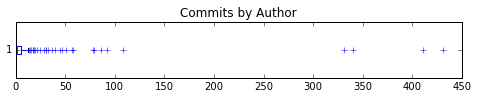

In [10]:
plt.figure(figsize=(8, 1)); plt.title('Commits by Author')
x = plt.boxplot([x[1] for x in all_commits_by_author.items()],vert=False)

### Same data in histogram form, clipping extreme values

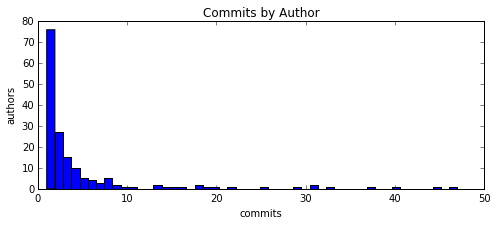

In [11]:
plt.figure(figsize=(8, 3))
plt.title('Commits by Author'); plt.xlabel('commits'); plt.ylabel('authors')
x = plt.hist([x[1] for x in all_commits_by_author.items() if x[1] <= 50], bins=50)

### Cumulative authorship, significant commits by authors with low commit counts

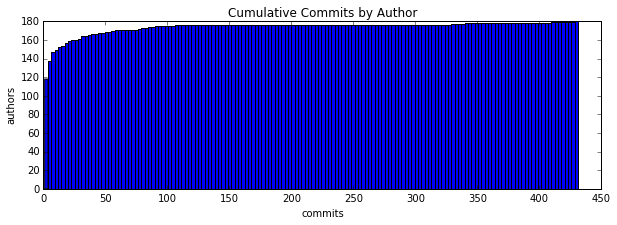

In [12]:
plt.figure(figsize=(10, 3))
plt.title('Cumulative Commits by Author'); plt.xlabel('commits'); plt.ylabel('authors')
x = plt.hist([x[1] for x in all_commits_by_author.items()], bins=160, cumulative=True)

### Drill down on top authors

In [13]:
print 'Top Authors:'; print '------------'
for author, commit_count in sorted(all_commits_by_author.items(), key=lambda x: x[1], reverse=True)[:10]:
    print author, commit_count

Top Authors:
------------
Author_16 431.0
Author_14 411.0
Author_165 340.0
Author_8 331.0
Author_9 108.0
Author_60 92.0
Author_81 86.0
Author_40 79.0
Author_35 78.0
Author_12 58.0


#Major Caveat

####The analysis approach below is based on a model of 'guilt by association'.  Specifically, that for each bug fix, guilt as apportioned based on authorship of code in proximity to code changes by the fix, where code that was replaced by the bug fix received the highest degree of guilt.  'Guilt' as used here is only an abstract concept, and by no means is a definitive indication of blame.  Perhaps a more appropriate term might be 'suspicion'.

Limitation:  Current analysis does not special case comments or whitespace when computing guilt.

# Explore Author's Association with Bugs (Guilt by association)

###### Note:  Analysis ignores all commits prior to cut-over to current Git+Launchpad_Gerrit toolchain

In [14]:
def get_upper_and_lower_limits(series, lower=1, upper=99):
    """Determine 1 and 99 Percentile values"""
    a = np.array([x[1] for x in series])
    lthresh = np.percentile(a,1)
    uthresh = np.percentile(a,99)
    return lthresh, uthresh


def remove_outliers(series, lower=1, upper=99):
    """Filtered version 1 - 99 Percentile"""
    lthresh, uthresh = get_upper_and_lower_limits(series, lower, upper)
    return [x for x in series if x[1] >= lthresh and x[1] <= uthresh]

In [15]:
guilt_by_author = get_guilt_by_author(combined_commits, min_order)
guilt_by_author = dict([[anonymize_name(k), v] for k, v in guilt_by_author.items()])

#normalize by author
norm_guilt_by_author = [[k, v/commits_by_author[k]]
                        for k, v in guilt_by_author.items()]

# author, commits, norm, total_errore
norm_guilt_vs_commit_count = [[k, all_commits_by_author[k],
                               v/ commits_by_author[k], v] 
                              for k, v in guilt_by_author.items()]

# Filtered version 1 - 99 Percentile
norm_guilt_by_commit_f = remove_outliers(norm_guilt_by_author, lower=1, upper=99)
_, max_commits = get_upper_and_lower_limits(all_commits_by_author.items())

norm_guilt_vs_commit_count = [[all_commits_by_author[k], norm_guilt] 
                              for k, norm_guilt in norm_guilt_by_commit_f
                              if all_commits_by_author[k] < max_commits]

log_norm_guilt_vs_commit_count = [[math.log(all_commits_by_author[k]), norm_guilt] 
                              for k, norm_guilt in norm_guilt_by_commit_f
                              if all_commits_by_author[k] < max_commits]

### Box Plot showing distribution of normalized guilt

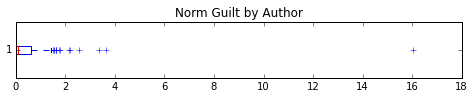

In [16]:
plt.figure(figsize=(8, 1)); plt.title('Norm Guilt by Author')
x = plt.boxplot([x[1] for x in norm_guilt_by_author],vert=False)

### Look at range relative to average author

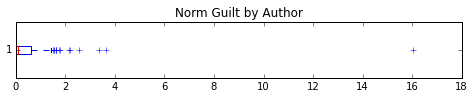

In [17]:
plt.figure(figsize=(8, 1)); plt.title('Norm Guilt by Author')

x = plt.boxplot([x[1] for x in norm_guilt_by_author],vert=False)

### Same data in histogram form

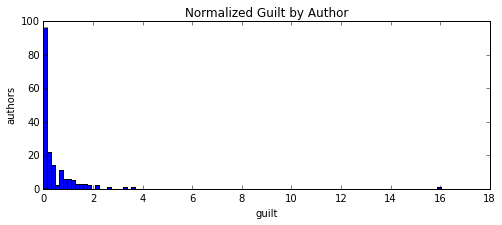

In [18]:
plt.figure(figsize=(8, 3))
plt.title('Normalized Guilt by Author'); plt.xlabel('guilt'); plt.ylabel('authors')
x = plt.hist([x[1] for x in norm_guilt_by_author], bins=100)

### Same data, ignoring outliers

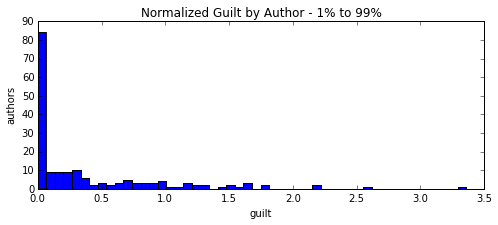

In [19]:
plt.figure(figsize=(8, 3))
plt.title('Normalized Guilt by Author - 1% to 99%'); plt.xlabel('guilt'); plt.ylabel('authors')
x = plt.hist([x[1] for x in norm_guilt_by_commit_f], bins=50)

### Look at individual authors

In [20]:
print 'Authors with Highest Normalized Guilt: (Significant Caveats Apply)'
print '--------------------------------------'
for author, norm_guilt in sorted([[k, v] for k, v in norm_guilt_by_author],
                                 key=lambda x: x[1], reverse=True)[:10]:
    print author, norm_guilt

Authors with Highest Normalized Guilt: (Significant Caveats Apply)
--------------------------------------
Author_138 16.0425966308
Author_100 3.65924618187
Author_22 3.35977437726
Author_33 2.56878012607
Author_117 2.21157118548
Author_87 2.16533312274
Author_145 1.77571301893
Author_128 1.76655244622
Author_164 1.64388821644
Author_158 1.64292410265


# Normalized Guilt vs Commit Experience

### Basic Scatter Plot

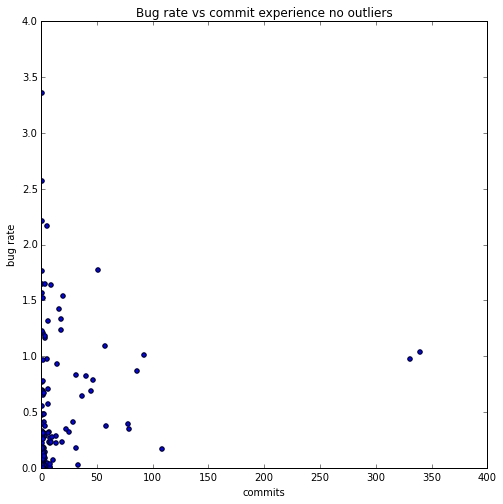

In [21]:
plt.figure(figsize=(8, 8))
plt.xlabel('commits'); plt.ylabel('bug rate'); plt.title('Bug rate vs commit experience no outliers')
x, y = zip(*norm_guilt_vs_commit_count)
plt.scatter(x, y); plt.xlim(0, ); plt.ylim(0, ); plt.show()

### Scatter plot with commit experience on log scale

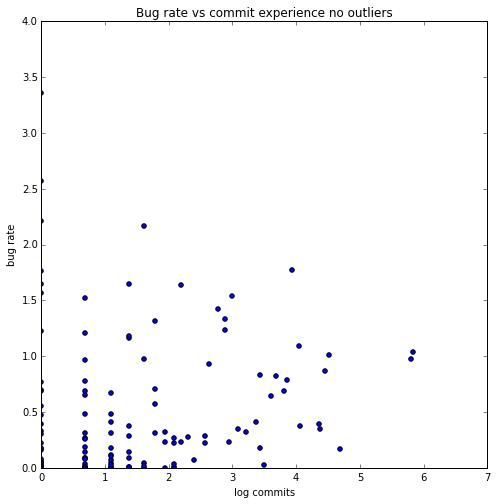

In [22]:
plt.figure(figsize=(8, 8))
plt.xlabel('log commits'); plt.ylabel('bug rate'); plt.title('Bug rate vs commit experience no outliers')
x, y = zip(*log_norm_guilt_vs_commit_count)
plt.scatter(x, y); plt.xlim(0, ); plt.ylim(0, ); plt.show()

# Cumulative contribution to overall guilt based on normalized guilt

In [36]:
def compute_cumulative(series):
    series = sorted(series, key=lambda x: x[1], reverse=True)    
    total = 0.0
    result = []
    for g, ng in series:
        total += g
        result.append([total, -ng])
    return result

In [45]:
guilt_vs_norm_guilt_by_author = [[v, v/commits_by_author[k]]
                        for k, v in guilt_by_author.items()]

cumulative_guilt = compute_cumulative(guilt_vs_norm_guilt_by_author)

n_authors = float(len(cumulative_guilt))
max_guilt = cumulative_guilt[-1][0]
relative_cumulative_guilt = [[100*float(i)/n_authors, v[0]/max_guilt ]
                             for i, v in enumerate(cumulative_guilt)]

# filtered versio of above
guilt_vs_norm_guilt_by_author_f = [[v, v/commits_by_author[k]]
                        for k, v in guilt_by_author.items()
                        if commits_by_author[k] > 10]

cumulative_guilt_f = compute_cumulative(guilt_vs_norm_guilt_by_author_f)

relative_cumulative_guilt_f = [[100*float(i)/n_authors, v[0]/max_guilt ]
                             for i, v in enumerate(cumulative_guilt_f)]

### Cumulative Guilt vs author error rate

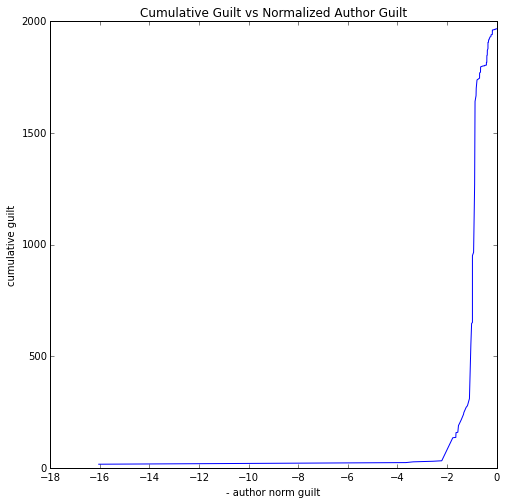

In [33]:
plt.figure(figsize=(8, 8))
plt.xlabel('- author norm guilt'); plt.ylabel('cumulative guilt'); plt.title('Cumulative Guilt vs Normalized Author Guilt')
y, x = zip(*cumulative_guilt)
plt.plot(x, y); plt.show()

###Overall Guilt Contribution based on Author Error Rate

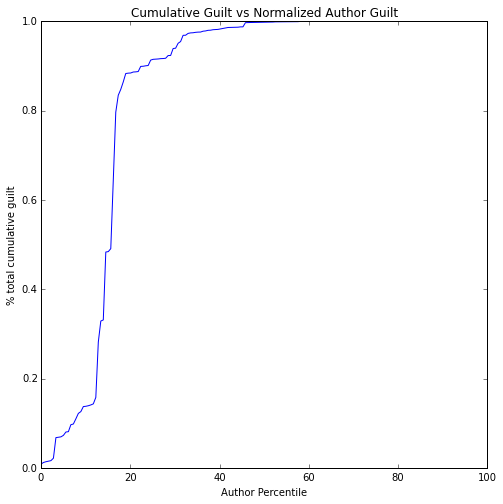

In [34]:
plt.figure(figsize=(8, 8))
plt.xlabel('Author Percentile'); plt.ylabel('% total cumulative guilt'); plt.title('Cumulative Guilt vs Normalized Author Guilt')
x, y = zip(*relative_cumulative_guilt)
plt.plot(x, y); plt.show()

######Note Below data skewed by large number of authors with zero guilt

###Overall Guilt Contribution based on Author Error Rate, ignoring authors with 10 or less commits

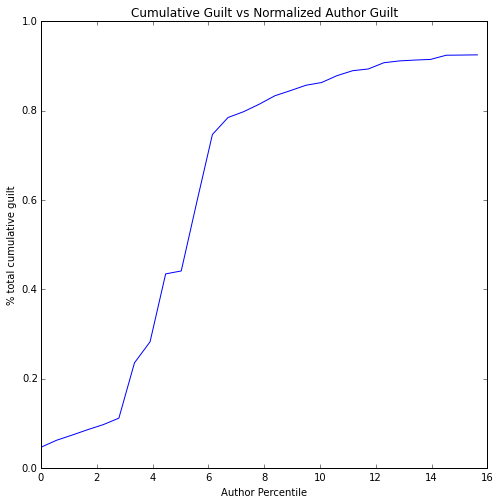

In [46]:
plt.figure(figsize=(8, 8))
plt.xlabel('Author Percentile'); plt.ylabel('% total cumulative guilt'); plt.title('Cumulative Guilt vs Normalized Author Guilt')
x, y = zip(*relative_cumulative_guilt_f)
plt.plot(x, y); plt.show()

###### The prolific authors appear to account for the vast majority of bugs.  Only 10% of guilt attributable to authors with 10 or fewer commits